In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [24]:
#load csv
df = pd.read_csv("data_daily.csv", names=["Date", "Receipt_Count"], skiprows=1, parse_dates=["Date"])

df = df.sort_values(by="Date")

#leave last 2 months for test
train_df = df[df["Date"] < "2021-11-01"]
test_df = df[df["Date"] >= "2021-11-01"]

In [25]:
def gen(data, l):
    x, y = [], []
    for i in range(len(data)-l):
        x.append(data[i:i+l])
        y.append(data[i+l])
    return np.array(x), np.array(y)

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val), min_val, max_val

#normalize data
train_scaled, n_min, n_max = normalize(train_df["Receipt_Count"].values)
test_scaled, _, _ = normalize(test_df["Receipt_Count"].values)

#create training and testing datasets
sequence_length = 30
x_train, y_train = gen(train_scaled, sequence_length)
x_test, y_test = gen(test_scaled, sequence_length)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [26]:
#use rnn because data may have some temporal dependencies
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=20, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/20


/Users/patrickli/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3059 - val_loss: 0.0563
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0410 - val_loss: 0.0422
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - val_loss: 0.0419
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - val_loss: 0.0416
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 0.0414
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - val_loss: 0.0416
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0423
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0422
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - val_loss: 0.0414
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - val_loss: 0.0415
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0414
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.04

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
rmse: 0.20812173010695767


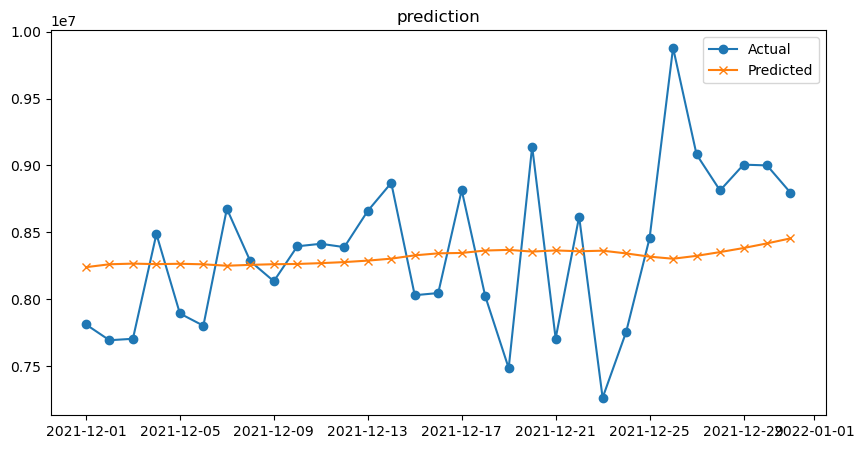

In [27]:
predictions = model.predict(x_test)


def rmse(actual, pred):
    msdiff = np.mean((actual - pred) ** 2)
    return np.sqrt(msdiff)

print("rmse:", rmse(y_test, predictions))

#inverse the normalization
predictions = predictions * (n_max - n_min) + n_min
y_test_actual = y_test * (n_max - n_min) + n_min


plt.figure(figsize=(10, 5))
plt.plot(test_df["Date"][sequence_length:], y_test_actual, label="Actual", marker='o')
plt.plot(test_df["Date"][sequence_length:], predictions, label="Predicted", marker='x')
plt.legend()
plt.title("prediction")
plt.show()

In [9]:
print("Actual y_test Shape:", y_test_actual.shape)
print("Predictions Shape:", predictions.shape)

Actual y_test Shape: (31, 1)
Predictions Shape: (31, 1)


In [57]:
#model.save("receipt_model.h5")

In [10]:
model.save('receipt_model.keras')